<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Classifier" data-toc-modified-id="Neural-Network-Classifier-1">Neural Network Classifier</a></span></li><li><span><a href="#Apply-NeuralNetworkClassifier-to-Handwritten-Digits" data-toc-modified-id="Apply-NeuralNetworkClassifier-to-Handwritten-Digits-2">Apply <code>NeuralNetworkClassifier</code> to Handwritten Digits</a></span></li><li><span><a href="#Experiments" data-toc-modified-id="Experiments-3">Experiments</a></span><ul class="toc-item"><li><span><a href="#Check-In" data-toc-modified-id="Check-In-3.1">Check-In</a></span></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-4">Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5">Extra Credit</a></span></li></ul></div>

# Neural Network Classifier

For this assignment, you will be adding code to the python script file `neuralnetworksA4.py` that you can download from [here](https://www.cs.colostate.edu/~anderson/cs545/notebooks/neuralnetworksA4.tar). This file currently contains the implementation of the `NeuralNetwork` class that is a solution to A3. It also contains an incomplete implementation of the subclass `NeuralNetworkClassifier` that extends `NeuralNetwork` as discussed in class.  You must complete this implementation. Your `NeuralNetworkClassifier` implementation should rely on inheriting functions from `NeuralNetwork` as much as possible. Your `neuralnetworksA4.py` file (notice it is plural) will now contain two classes, `NeuralNetwork` and `NeuralNetworkClassifier`.

In `NeuralNetworkClassifier` you will replace the `_error_f` function with one called `_neg_log_likelihood_f`. You will also have to define a new version of the `_gradient_f` function for `NeuralNetworkClassifier`.

Here are some example tests.

In [1]:
%%writefile neuralnetworksA4.py

import numpy as np
import optimizers as opt
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():

    """
    A class that represents a neural network for nonlinear regression.

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hidden_units_by_layers : list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs : int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
    total_epochs : int
        Total number of epochs trained so far
    performance_trace : list of floats
        Mean square error (unstandardized) after each epoch
    n_epochs : int
        Number of epochs trained so far
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
    debug : boolean
        If True, print information to help with debugging
        
    Methods
    -------
    make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(X, T, n_epochs, method='sgd', learning_rate=None, verbose=True)
        Trains the network using input and target samples by rows in X and T

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hiddens_each_layer, n_outputs):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hidden_units_by_layers : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        self.n_inputs = n_inputs
        self.n_hiddens_each_layer = n_hiddens_each_layer
        self.n_outputs = n_outputs

        # Create one-dimensional numpy array of all weights with random initial values

        shapes = []
        n_in = n_inputs
        for nu in self.n_hiddens_each_layer + [n_outputs]:
            shapes.append((n_in + 1, nu))
            n_in = nu

        # Build list of views (pairs of number of rows and number of columns)
        # by reshaping corresponding elements from vector of all weights 
        # into correct shape for each layer.        

        self.all_weights, self.Ws = self.make_weights_and_views(shapes)
        self.all_gradients, self.Grads = self.make_weights_and_views(shapes)

        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None

        self.total_epochs = 0
        self.performance = None
        self.performance_trace = []
        self.debug = False
        
    def __repr__(self):
        return '{}({}, {}, {})'.format(type(self).__name__, self.n_inputs, self.n_hiddens_each_layer, self.n_outputs)

    def __str__(self):
        s = self.__repr__()
        if self.total_epochs > 0:
            s += '\n Trained for {} epochs.'.format(self.total_epochs)
            s += '\n Final standardized RMSE {:.4g}.'.format(self.performance_trace[-1])
        return s
 
    def make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer.
            Number of rows is number of inputs to layer (including constant 1).
            Number of columns is number of units, or outputs, in layer.

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Make vector of all weights by stacking vectors of weights one layer at a time
        # Divide each layer's weights by square root of number of inputs
        all_weights = np.hstack([np.random.uniform(-1, 1, size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])

        # Build weight matrices as list of views (pairs of number of rows and number 
        # of columns) by reshaping corresponding elements from vector of all weights 
        # into correct shape for each layer.  
        # Do the same to make list of views for gradients.
 
        views = []
        first_element = 0
        for shape in shapes:
            n_elements = shape[0] * shape[1]
            last_element = first_element + n_elements
            views.append(all_weights[first_element:last_element].reshape(shape))
            first_element = last_element

        # Set output layer weights to zero.
        views[-1][:] = 0
        
        return all_weights, views

    def set_debug(self, d):
        """Set or unset printing of debugging information.

        Parameters
        ----------
        d : boolean
            If True, print debugging information. 
        """
        
        self.debug = d
        if self.debug:
            print('Debugging information will now be printed.')
        else:
            print('No debugging information will be printed.')
        
    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights.

        Parameters
        ----------
        X : two-dimensional numpy array 
            number of samples  by  number of input components
        T : two-dimensional numpy array
            number of samples  by  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements

        Returns
        -------
        self : NeuralNetwork instance
        """

        # Calculate and assign standardization parameters

        if self.X_means is None:
            self.X_means = X.mean(axis=0)
            self.X_stds = X.std(axis=0)
            self.X_stds[self.X_stds == 0] = 1
            self.T_means = T.mean(axis=0)
            self.T_stds = T.std(axis=0)

        # Standardize X and T.  Assign back to X and T.

        X = (X - self.X_means) / self.X_stds
        T = (T - self.T_means) / self.T_stds

        # Instantiate Optimizers object by giving it vector of all weights
        
        optimizer = opt.Optimizers(self.all_weights)

        # Define function to convert mean-square error to root-mean-square error,
        # Here we use a lambda function just to illustrate its use.  
        # We could have also defined this function with
        # def error_convert_f(err):
        #     return np.sqrt(err)

        error_convert_f = lambda err: np.sqrt(err)

        # Call the requested optimizer method to train the weights.

        if method == 'sgd':

            performance_trace = optimizer.sgd(self._error_f, self._gradient_f,
                                              fargs=[X, T], n_epochs=n_epochs,
                                              learning_rate=learning_rate,
                                              error_convert_f=error_convert_f,
                                              error_convert_name='RMSE',
                                              verbose=verbose)

        elif method == 'adam':

            performance_trace = optimizer.adam(self._error_f, self._gradient_f,
                                               fargs=[X, T], n_epochs=n_epochs,
                                               learning_rate=learning_rate,
                                               error_convert_f=error_convert_f,
                                               error_convert_name='RMSE',
                                               verbose=verbose)

        elif method == 'scg':

            performance_trace = optimizer.scg(self._error_f, self._gradient_f,
                                              fargs=[X, T], n_epochs=n_epochs,
                                              error_convert_f=error_convert_f,
                                              error_convert_name='RMSE',
                                              verbose=verbose)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.total_epochs += len(performance_trace)
        self.performance_trace += performance_trace

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _add_ones(self, X):
        return np.insert(X, 0, 1, 1)
    
    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X.
        
        Parameters
        ----------
        X : input samples, standardized with first column of constant 1's.

        Returns
        -------
        Standardized outputs of all layers as list, include X as first element.
        """

        self.Zs = [X]

        # Append output of each layer to list in self.Zs, then return it.

        for W in self.Ws[:-1]:  # forward through all but last layer
            self.Zs.append(np.tanh(self._add_ones(self.Zs[-1]) @ W))
        last_W = self.Ws[-1]
        self.Zs.append(self._add_ones(self.Zs[-1]) @ last_W)

        return self.Zs

    # Function to be minimized by optimizer method, mean squared error
    def _error_f(self, X, T):
        """Calculate output of net given input X and its mean squared error.
        Function to be minimized by optimizer.

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  by  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  by  number of output components

        Returns
        -------
        Standardized mean square error as scalar float that is the mean
        square error over all samples and all network outputs.
        """

        if self.debug:
            print('in _error_f: X[0] is {} and T[0] is {}'.format(X[0], T[0]))
        Zs = self._forward(X)
        mean_sq_error = np.mean((T - Zs[-1]) ** 2)
        if self.debug:
            print(f'in _error_f: mse is {mean_sq_error}')
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def _gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called
        so input and all layer outputs stored in self.Zs

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  x  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Zs.

        if self.debug:
            print('in _gradient_f: X[0] is {} and T[0] is {}'.format(X[0], T[0]))
        n_samples = X.shape[0]
        n_outputs = T.shape[1]

        # delta is delta matrix to be back propagated.
        # Dividing by n_samples and n_outputs here replaces the scaling of
        # the learning rate.

        delta = -(T - self.Zs[-1]) / (n_samples * n_outputs)

        # Step backwards through the layers to back-propagate the error (delta)
        self._backpropagate(self, delta)

        return self.all_gradients

    def _backpropagate(self, delta):
        """Backpropagate output layer delta through all previous layers,
        setting self.Grads, the gradient of the objective function wrt weights in each layer.

        Parameters
        ----------
        delta : two-dimensional numpy array of output layer delta values
            number of samples  x  number of output components
        """

        n_layers = len(self.n_hiddens_each_layer) + 1
        if self.debug:
            print('in _gradient_f: first delta calculated is\n{}'.format(delta))
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.Grads[layeri][:] = self._add_ones(self.Zs[layeri]).T @ delta
            # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Zs[layeri] ** 2)
                if self.debug:
                    print('in _gradient_f: next delta is\n{}'.format(delta))

    def use(self, X):
        """Return the output of the network for input samples as rows in X.
        X assumed to not be standardized.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  by  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  by  number of outputs
        """

        # Standardize X
        X = (X - self.X_means) / self.X_stds
        Zs = self._forward(X)
        # Unstandardize output Y before returning it
        return Zs[-1] * self.T_stds + self.T_means

    def get_performance_trace(self):
        """Returns list of unstandardized root-mean square error for each epoch"""
        return self.performance_trace


######################################################################
## class NeuralNetworkClassifier(NeuralNetwork)
######################################################################
class NeuralNetworkClassifier(NeuralNetwork):
    
    def __str__(self):
        s = self.__repr__()  # using NeuralNetwork.__repr__()
        if self.total_epochs > 0:
            s += '\n Trained for {} epochs.'.format(self.total_epochs)
            s += '\n Final data likelihood {:.4g}.'.format(self.performance_trace[-1])
        return s
 
    def _make_indicator_vars(self, T):
        """Convert column matrix of class labels (ints or strs) into indicator variables

        Parameters
        ----------
        T : two-dimensional array of all ints or all strings
            number of samples by 1
        
        Returns
        -------
        Two dimensional array of indicator variables. Each row is all 0's except one value of 1.
            number of samples by number of output components (number of classes)
        """

        # Make sure T is two-dimensional. Should be n_samples x 1.
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(float)  # to work on GPU

    def _softmax(self, Y):
        """Convert output Y to exp(Y) / (sum of exp(Y)'s)

        Parameters
        ----------
        Y : two-dimensional array of network output values
            number of samples by number of output components (number of classes)

        Returns
        -------
        Two-dimensional array of indicator variables representing Y
            number of samples by number of output components (number of classes)
        """

        # Trick to avoid overflow
        # maxY = max(0, self.max(Y))
        maxY = Y.max()  #self.max(Y))        
        expY = np.exp(Y - maxY)
        denom = expY.sum(1).reshape((-1, 1))
        Y_softmax = expY / (denom + sys.float_info.epsilon)
        return Y_softmax

    # Function to be minimized by optimizer method, mean squared error
    def _neg_log_likelihood_f(self, X, T):
        """Calculate output of net given input X and the resulting negative log likelihood.
        Function to be minimized by optimizer.

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  by  number of input components
        T : two-dimensional numpy array of class indicator variables
            number of samples  by  number of output components (number of classes)

        Returns
        -------
        Negative log likelihood as scalar float.
        """
        Y = self._softmax(self._forward(X)[-1])
        neg_mean_log_likelihood =  - np.mean(T * np.log(Y + sys.float_info.epsilon))  # T should be indicator variable

        return neg_mean_log_likelihood

    def _gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward (from NeuralNetwork class)
        has already called so input and all layer outputs stored in self.Zs

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  x  number of input components
        T : two-dimensional numpy array of class indicator variables
            number of samples  by  number of output components (number of classes)

        Returns
        -------
        Vector of gradients of negative log likelihood wrt all weights
        """

        n_samples = X.shape[0]
        n_outputs = T.shape[1]

        # delta is delta matrix to be back propagated.
        # Dividing by n_samples and n_outputs here replaces the scaling of
        # the learning rate.

        delta = -(T - self._softmax(self.Zs[-1])) / (n_samples * n_outputs)

        # Step backwards through the layers to back-propagate the error (delta)
        self._backpropagate(delta)

        return self.all_gradients
                    

    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights.

        Parameters
        ----------
        X : two-dimensional numpy array 
            number of samples  by  number of input components
        T : two-dimensional numpy array of target classes, as ints or strings
            number of samples  by  1
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements

        Returns
        -------
        self : NeuralNetworkClassifier instance
        """

        # Calculate and assign standardization parameters

        if self.X_means is None:
            self.X_means = X.mean(axis=0)
            self.X_stds = X.std(axis=0)
            self.X_stds[self.X_stds == 0] = 1
            # Not standardizing target classes.

        # Standardize X and assign back to X.

        X = (X - self.X_means) / self.X_stds

        # Assign class labels to self.classes, and counts of each to counts.
        # Create indicator values representation from target labels in T.

        self.classes, counts = np.unique(T, return_counts=True)
        T_ind_vars = self._make_indicator_vars(T)

        # Instantiate Optimizers object by giving it vector of all weights.
        optimizer = opt.Optimizers(self.all_weights)

        # Define function to convert negative log likelihood values to likelihood values.

        _error_convert_f = lambda nll: np.exp(-nll)

        if method == 'sgd':

            performance_trace = optimizer.sgd(self._neg_log_likelihood_f,
                                            self._gradient_f,
                                            fargs=[X, T_ind_vars], n_epochs=n_epochs,
                                            learning_rate=learning_rate,
                                            error_convert_f=_error_convert_f,
                                            error_convert_name='Likelihood',
                                            verbose=verbose)

        elif method == 'adam':

            performance_trace = optimizer.adam(self._neg_log_likelihood_f,
                                               self._gradient_f,
                                               fargs=[X, T_ind_vars], n_epochs=n_epochs,
                                               learning_rate=learning_rate,
                                               error_convert_f=_error_convert_f,
                                               error_convert_name='Likelihood',
                                               verbose=verbose)

        elif method == 'scg':

            performance_trace = optimizer.scg(self._neg_log_likelihood_f,
                                              self._gradient_f,
                                              fargs=[X, T_ind_vars], n_epochs=n_epochs,
                                              error_convert_f=_error_convert_f,
                                              error_convert_name='Likelihood',
                                              verbose=verbose)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.total_epochs += len(performance_trace)
        self.performance_trace += performance_trace

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def use(self, X):
        """Return the predicted class and probabilities for input samples as rows in X.
        X assumed to not be standardized.

        Parameters
        ----------
        X : two-dimensional numpy array, unstandardized input samples by rows
            number of samples  by  number of input components, unstandardized

        Returns
        -------
        Classes (Predicted classes) : two-dimensional array of predicted classes for each sample
            number of samples by 1  of ints or strings, depending on how target classes were specified
        Y (Class probabilities)  : Two_dimensional array of probabilities of each class for each sample
            number of samples by number of outputs (number of classes)
        """

        # Standardize X
        X = (X - self.X_means) / self.X_stds

        Y_softmax = self._softmax(self._forward(X)[-1])
        Y = Y_softmax
        
        pred_idx = np.argmax(Y_softmax, axis=1)
        classes = np.array([self.classes[idx] for idx in pred_idx]).reshape(-1, 1)
     
        return classes, Y

Overwriting neuralnetworksA4.py


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
import neuralnetworksA4 as nn

In [75]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
T = np.array([[0], [1], [1], [0]])
X, T

(array([[0, 0],
        [1, 0],
        [0, 1],
        [1, 1]]),
 array([[0],
        [1],
        [1],
        [0]]))

In [76]:
np.random.seed(111)
nnet = nn.NeuralNetworkClassifier(2, [10], 2)

In [77]:
print(nnet)

NeuralNetworkClassifier(2, [10], 2)


In [78]:
nnet.Ws

[array([[ 0.12952296, -0.38212533, -0.07383268,  0.31091752, -0.23633798,
         -0.40511172, -0.55139454, -0.09211682, -0.30174387, -0.18745848],
        [ 0.56662595, -0.3028474 , -0.48359706,  0.19583749,  0.13999926,
         -0.26066957, -0.03900416, -0.44067096, -0.49195143,  0.46277416],
        [ 0.33943873,  0.39325596,  0.36397022,  0.56690583,  0.08922813,
          0.36230683, -0.09085429, -0.5456561 , -0.05295844, -0.45573018]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

The `_error_f` function is replaced with `_neg_log_likelihood`.  If you add some print statements in `_neg_log_likelihood` functions, you can compare your output to the following results.

In [79]:
nnet.set_debug(True)

Debugging information will now be printed.


In [80]:
nnet.train(X, T, n_epochs=1, method='sgd', learning_rate=0.01)

in _gradient_f: first delta calculated is
[[-0.0625  0.0625]
 [ 0.0625 -0.0625]
 [ 0.0625 -0.0625]
 [-0.0625  0.0625]]
in _gradient_f: next delta is
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
sgd: Epoch 1 Likelihood=0.70711


NeuralNetworkClassifier(2, [10], 2)

In [81]:
nnet.set_debug(False)

No debugging information will be printed.


In [82]:
print(nnet)

NeuralNetworkClassifier(2, [10], 2)
 Trained for 1 epochs.
 Final data likelihood 0.7071.


Now if you comment out those print statements, you can run for more epochs without tons of output.

In [83]:
np.random.seed(111)
nnet = nn.NeuralNetworkClassifier(2, [10], 2)

In [84]:
nnet.train(X, T, 100, method='scg')

SCG: Iteration 10 Likelihood=0.99776
SCG: Iteration 20 Likelihood=0.99998
SCG: Iteration 30 Likelihood=1.00000


NeuralNetworkClassifier(2, [10], 2)

The `use()` function returns two `numpy` arrays. The first one are the class predictions for eachs sample, containing values from the set of unique values in `T` passed into the `train()` function.

The second value are the probabilities of each class for each sample. This should a column for each unique value in `T`.

In [85]:
nnet.use(X)

(array([[0],
        [1],
        [1],
        [0]]),
 array([[9.99999993e-01, 6.83570212e-09],
        [1.18953087e-08, 9.99999988e-01],
        [7.27613919e-09, 9.99999993e-01],
        [9.99999978e-01, 2.22308025e-08]]))

In [86]:
def percent_correct(Y, T):
    return np.mean(T == Y) * 100

In [87]:
percent_correct(nnet.use(X)[0], T)

100.0

Works!  The XOR problem was used early in the history of neural networks as a problem that cannot be solved with a linear model.  Let's try it.  It turns out our neural network code can do this if we use an empty list for the hidden unit structure!

In [88]:
nnet = nn.NeuralNetworkClassifier(2, [], 2)
nnet.train(X, T, 100, method='scg')

NeuralNetworkClassifier(2, [], 2)

In [89]:
nnet.use(X)

(array([[0],
        [0],
        [0],
        [0]]),
 array([[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]]))

In [90]:
percent_correct(nnet.use(X)[0], T)

50.0

A second way to evaluate a classifier is to calculate a confusion matrix. This shows the percent accuracy for each class, and also shows which classes are predicted in error.

Here is a function you can use to show a confusion matrix.

In [91]:
import pandas

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

In [92]:
confusion_matrix(nnet.use(X)[0], T)

Percent Correct


# Apply `NeuralNetworkClassifier` to Handwritten Digits

Apply your `NeuralNetworkClassifier` to the [MNIST digits dataset](https://www.cs.colostate.edu/~anderson/cs545/notebooks/mnist.pkl.gz).

In [1]:
import pickle
import gzip

In [2]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [95]:
28*28

784

In [96]:
# This represents 1 image
Xtrain[5].shape

(784,)

In [97]:
Ttrain[5, 0] # label of the Xtrain[5] image

2

In [98]:
def draw_image(image, label, predicted_label=None):
    plt.imshow(- image.reshape(28, 28), cmap='gray')  # adding the '-' sign inverts cmap scale
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    title = str(label)
    color = 'black'
    if predicted_label is not None:
        title += ' as {}'.format(predicted_label)
        if predicted_label != label:
            color = 'red'
    plt.title(title, color=color)

<IPython.core.display.Javascript object>


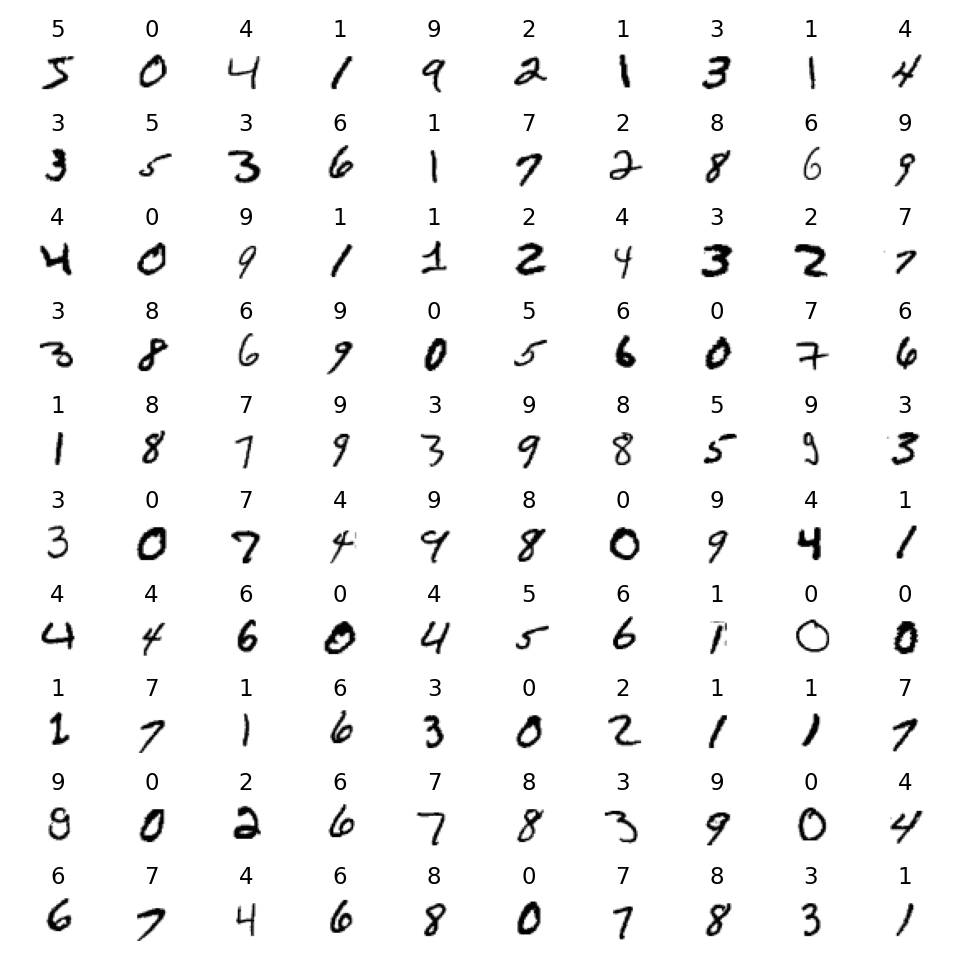

In [99]:
plt.figure(figsize=(7, 7))
for i in range(100):
    plt.subplot(10, 10, i+1)
    draw_image(Xtrain[i], Ttrain[i, 0])
plt.tight_layout()

In [32]:
nnet = nn.NeuralNetworkClassifier(784, [], 10)  
# 784 inputs as each of the 784 images will work as a input column. 10 output refers to 10 numbers (classes) from 0-9
nnet.train(Xtrain, Ttrain, n_epochs=40, method='scg')

SCG: Iteration 4 Likelihood=0.95899
SCG: Iteration 8 Likelihood=0.97016
SCG: Iteration 12 Likelihood=0.97302
SCG: Iteration 16 Likelihood=0.97371
SCG: Iteration 20 Likelihood=0.97371
SCG: Iteration 24 Likelihood=0.97371
SCG: Iteration 28 Likelihood=0.97371
SCG: Iteration 32 Likelihood=0.97420
SCG: Iteration 36 Likelihood=0.97551
SCG: Iteration 40 Likelihood=0.97607


NeuralNetworkClassifier(784, [], 10)

In [34]:
print(nnet)

NeuralNetworkClassifier(784, [], 10)
 Trained for 41 epochs.
 Final data likelihood 0.9761.


In [35]:
# checking train, validation, and test accuracy 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[93.24, 92.72, 92.25999999999999]

In [36]:
confusion_matrix(nnet.use(Xtest)[0], Ttest)

Percent Correct


In [37]:
nnet = nn.NeuralNetworkClassifier(784, [20], 10)
nnet.train(Xtrain, Ttrain, n_epochs=40, method='scg')

SCG: Iteration 4 Likelihood=0.85225
SCG: Iteration 8 Likelihood=0.88189
SCG: Iteration 12 Likelihood=0.94317
SCG: Iteration 16 Likelihood=0.96105
SCG: Iteration 20 Likelihood=0.96537
SCG: Iteration 24 Likelihood=0.96972
SCG: Iteration 28 Likelihood=0.97296
SCG: Iteration 32 Likelihood=0.97555
SCG: Iteration 36 Likelihood=0.97857
SCG: Iteration 40 Likelihood=0.98063


NeuralNetworkClassifier(784, [20], 10)

In [39]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest],
                                                    [Ttrain, Tval, Ttest])]

[94.342, 93.55, 93.05]

In [53]:
confusion_matrix(nnet.use(Xtest)[0], Ttest)

Percent Correct


<IPython.core.display.Javascript object>


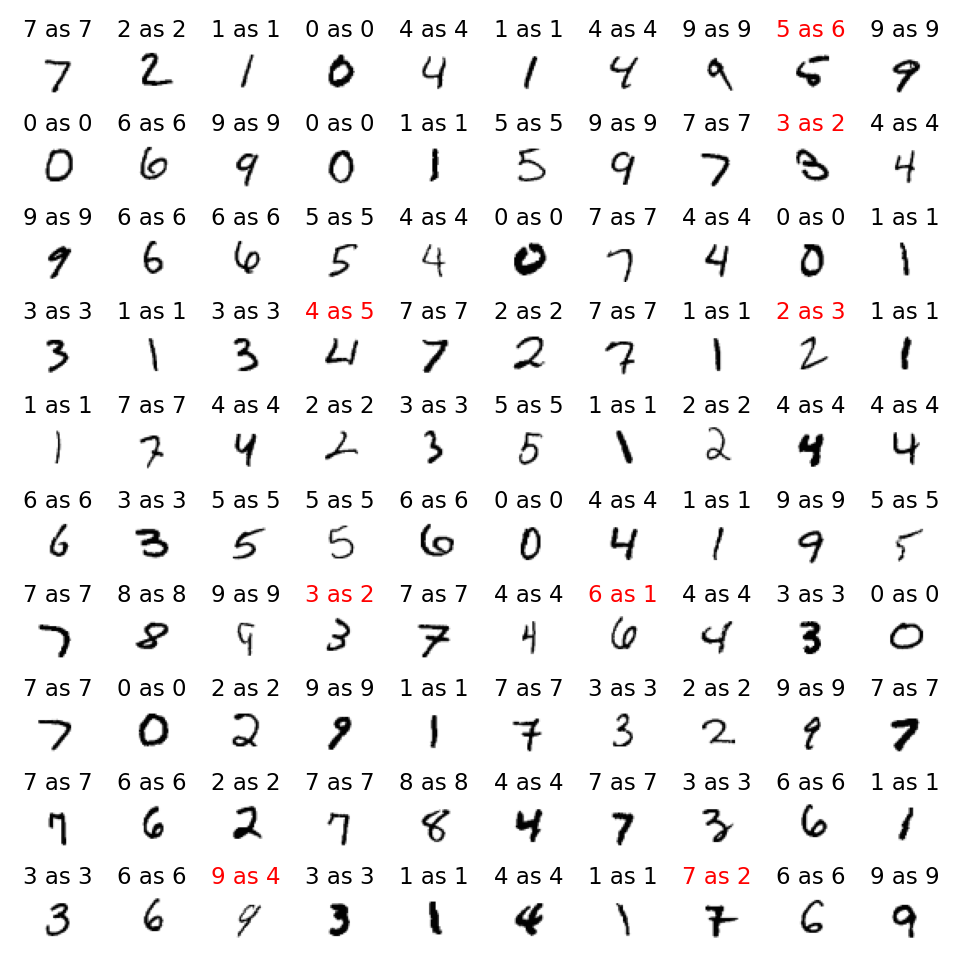

In [41]:
plt.figure(figsize=(7, 7))
Ytest, _ = nnet.use(Xtest[:100, :])
for i in range(100):
    plt.subplot(10, 10, i + 1)
    draw_image(Xtest[i], Ttest[i, 0], Ytest[i, 0])
plt.tight_layout()

# Experiments

For each method, try various hidden layer structures, learning rates, and numbers of epochs.  Use the validation percent accuracy to pick the best hidden layers, learning rates and numbers of epochs for each method (ignore learning rates for scg).  Report training, validation and test accuracy for your best validation results for each of the three methods.

Include plots of data likelihood versus epochs, and confusion matrices, for best results for each method.

Write at least 10 sentences about what you observe in the likelihood plots, the train, validation and test accuracies, and the confusion matrices.

In [3]:
import pandas as pd
import itertools


def percent_accuracy(Y, T):
    """
    Calculates percent accuracy for observed (T) and predicted (Y) data.
    """
    return np.mean(T == Y) * 100

def confusion_matrix(Y_classes, T):
    """
    Generates confusion matrix comparing observed (T) and predicted (Y_classes) data.
    """
    class_names = np.unique(T)
    table = []
    
    for true_class in class_names:
        row = []
        for pred_class in class_names:
            # 'Y_classes[T == true_class] == pred_class' generates a True, False matrix. np.mean counts and averages that.
            row.append(100 * np.mean(Y_classes[T == true_class] == pred_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
#     print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")



def make_param_grid(structure, rho, epoch):
    """
    Makes a gridspace with all possible combinations of input parameters.
    
    :param structure: list of int
                      Number of units in each hidden layers. Each element of the list represents one hidden layer.
    :param rho: float
                Learning rate of the model.
    :param epoch: int
                  Number of epoch to run the model.
                  
    :return: A list of all parameter combinations.
    """
    param_combs = list(itertools.product(*[structure, rho, epoch]))
    return param_combs


def configure_nnet_model(X_train, X_val, X_test, T_train, T_val, T_test, structures, rhos, epochs, method):
    """
    Runs the model for number of times of parameter combinations and saves model layout, train rmse, and test rmse. 
    
    :param X_train, X_val, X_test, T_train, T_val, T_test: Train, validation and test datasets.
    
    :param structures: A nested list of int, such as [[50, 20], [30, 10]]
                       Number of units in each hidden layers. Each element of the list represents one hidden layer.
    :param rhos: list of float
                 Learning rate of the model.
    :param epochs: list of int
                   Number of epoch to run the model.
    :param method : str
                    Optimization method. Accepted str from - 'sgd', 'adam', or 'scg'.
    
    :return: A dataframe with model layouts and respective train test rmse.
    """
    import neuralnetworksA4 as nn
    
    parameter_combinations = make_param_grid(structures, rhos, epochs)


    n_inputs, n_outputs = X_train.shape[1], len(np.unique(T_train))

    result_dict = {'Method': [], 'Structure': [], 'Epochs': [], 'Learning Rate': [], 'Train Acc': [], 
                   'Validation Acc': [], 'Test Acc': []}

    for params in parameter_combinations:
        hidden_layers, rho, epoch = params
        nn_model = nn.NeuralNetworkClassifier(n_inputs, hidden_layers, n_outputs)
        nn_model.train(X_train, T_train, n_epochs=epoch, method=method, learning_rate=rho, verbose=False)
        
        # Percent Accuracy for train, validation, and test set
        Ttrain_pred, _ = nn_model.use(X_train)
        Tval_pred, _ = nn_model.use(X_val)
        Ttest_pred, _ = nn_model.use(X_test)
        
        train_accr, val_accr, test_accr = [percent_accuracy(pred, obs) for obs, pred in 
                                           zip((T_train, T_val, T_test), (Ttrain_pred, Tval_pred, Ttest_pred))]
        
        print(f'Training for {method=}, {hidden_layers=}, {rho=}, {epoch=}')
        print(f'Train acc. {train_accr:.2f}, Val. acc {val_accr:.2f}, Test acc {test_accr:.2f}')
        print('##############################')
        
        # appending results to the result dictionary
        result_dict['Method'].append(method)
        result_dict['Structure'].append(hidden_layers)
        result_dict['Epochs'].append(epoch)
        result_dict['Learning Rate'].append(rho)
        result_dict['Train Acc'].append(train_accr)
        result_dict['Validation Acc'].append(val_accr)
        result_dict['Test Acc'].append(test_accr)

    result_df = pd.DataFrame(result_dict)
    result_df.sort_values(by=['Validation Acc'], axis=0, ascending=False, inplace=True)

    return result_df

# SGD

In [47]:
# Searching for best model layout
nnet_structure = [[30, 10], [10, 10, 5, 5]]
nnet_rho = [0.01, 0.1]
nnet_epoch = [100, 250, 400]

In [157]:
sgd_results = configure_nnet_model(Xtrain, Xval, Xtest, Ttrain, Tval, Ttest, nnet_structure, nnet_rho, 
                                   nnet_epoch, method='sgd')
sgd_results

Training for method='sgd', hidden_layers=[30, 10], rho=0.01, epoch=100
Train acc. 31.06, Val. acc 31.87, Test acc 32.51
##############################
Training for method='sgd', hidden_layers=[30, 10], rho=0.01, epoch=250
Train acc. 34.43, Val. acc 34.57, Test acc 34.43
##############################
Training for method='sgd', hidden_layers=[30, 10], rho=0.01, epoch=400
Train acc. 47.60, Val. acc 47.97, Test acc 47.98
##############################
Training for method='sgd', hidden_layers=[30, 10], rho=0.1, epoch=100
Train acc. 55.90, Val. acc 56.38, Test acc 56.49
##############################
Training for method='sgd', hidden_layers=[30, 10], rho=0.1, epoch=250
Train acc. 85.09, Val. acc 86.57, Test acc 85.71
##############################
Training for method='sgd', hidden_layers=[30, 10], rho=0.1, epoch=400
Train acc. 89.44, Val. acc 90.15, Test acc 89.40
##############################
Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch=100
Train acc. 11.36, Va

Method       Structure  Epochs  Learning Rate  Train Acc  Validation Acc  \
5     sgd        [30, 10]     400           0.10     89.444           90.15   
4     sgd        [30, 10]     250           0.10     85.094           86.57   
3     sgd        [30, 10]     100           0.10     55.902           56.38   
2     sgd        [30, 10]     400           0.01     47.604           47.97   
11    sgd  [10, 10, 5, 5]     400           0.10     40.926           41.81   
1     sgd        [30, 10]     250           0.01     34.428           34.57   
0     sgd        [30, 10]     100           0.01     31.056           31.87   
10    sgd  [10, 10, 5, 5]     250           0.10     21.282           20.72   
9     sgd  [10, 10, 5, 5]     100           0.10     16.662           15.92   
6     sgd  [10, 10, 5, 5]     100           0.01     11.356           10.64   
7     sgd  [10, 10, 5, 5]     250           0.01     11.356           10.64   
8     sgd  [10, 10, 5, 5]     400           0.01     11.356           10.64   

    Test Acc  
5      89.40  
4      85.71  
3      56.49  
2      47.98  
11     40.64  
1      34.43  
0      32.51  
10     21.39  
9      16.50  
6      11.35  
7      11.35  
8      11.35

The best model for `SGD` has a structure `[30, 10]`, learning rate `0.10`, and epoch `400`.


This model has a train accuracy <b> 89.44 </b>, validation accuracy <b>90.15</b>, and test accuracy <b>89.40</b>.

# Adam

In [49]:
adam_results = configure_nnet_model(Xtrain, Xval, Xtest, Ttrain, Tval, Ttest, nnet_structure, nnet_rho, 
                                   nnet_epoch, method='adam')
adam_results

Training for method='adam', hidden_layers=[30, 10], rho=0.01, epoch=100
Train acc. 96.21, Val. acc 91.91, Test acc 91.85
##############################
Training for method='adam', hidden_layers=[30, 10], rho=0.01, epoch=250
Train acc. 98.66, Val. acc 92.17, Test acc 91.88
##############################
Training for method='adam', hidden_layers=[30, 10], rho=0.01, epoch=400
Train acc. 98.11, Val. acc 91.04, Test acc 90.49
##############################
Training for method='adam', hidden_layers=[30, 10], rho=0.1, epoch=100
Train acc. 94.68, Val. acc 91.11, Test acc 90.63
##############################
Training for method='adam', hidden_layers=[30, 10], rho=0.1, epoch=250
Train acc. 95.61, Val. acc 90.30, Test acc 90.00
##############################
Training for method='adam', hidden_layers=[30, 10], rho=0.1, epoch=400
Train acc. 96.35, Val. acc 90.27, Test acc 89.25
##############################
Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch=100
Train acc. 43

Method       Structure  Epochs  Learning Rate  Train Acc  Validation Acc  \
1    adam        [30, 10]     250           0.01     98.664           92.17   
0    adam        [30, 10]     100           0.01     96.212           91.91   
3    adam        [30, 10]     100           0.10     94.680           91.11   
2    adam        [30, 10]     400           0.01     98.108           91.04   
4    adam        [30, 10]     250           0.10     95.612           90.30   
5    adam        [30, 10]     400           0.10     96.354           90.27   
11   adam  [10, 10, 5, 5]     400           0.10     91.602           88.58   
10   adam  [10, 10, 5, 5]     250           0.10     89.966           87.82   
9    adam  [10, 10, 5, 5]     100           0.10     88.182           87.27   
8    adam  [10, 10, 5, 5]     400           0.01     86.448           80.32   
7    adam  [10, 10, 5, 5]     250           0.01     73.310           69.81   
6    adam  [10, 10, 5, 5]     100           0.01     43.368           41.44   

    Test Acc  
1      91.88  
0      91.85  
3      90.63  
2      90.49  
4      90.00  
5      89.25  
11     88.43  
10     87.01  
9      86.12  
8      80.69  
7      67.93  
6      42.08

The best model for `Adam` has a structure `[30, 10]`, learning rate `0.01`, and epoch `250`.


This model has a train accuracy <b> 98.66 </b>, validation accuracy <b>92.17</b>, and test accuracy <b>91.88</b>.

# SCG

In [159]:
# Searching for best model layout
nnet_structure = [[30, 10], [10, 10, 5, 5]]
nnet_epoch = [100, 250, 400]

In [160]:
scg_results = configure_nnet_model(Xtrain, Xval, Xtest, Ttrain, Tval, Ttest, nnet_structure, nnet_rho, 
                                   nnet_epoch, method='scg')
scg_results

Training for method='scg', hidden_layers=[30, 10], rho=0.01, epoch=100
Train acc. 99.79, Val. acc 92.88, Test acc 93.02
##############################
Training for method='scg', hidden_layers=[30, 10], rho=0.01, epoch=250
Train acc. 99.98, Val. acc 93.03, Test acc 92.61
##############################
Training for method='scg', hidden_layers=[30, 10], rho=0.01, epoch=400
Train acc. 100.00, Val. acc 92.87, Test acc 92.56
##############################
Training for method='scg', hidden_layers=[30, 10], rho=0.1, epoch=100
Train acc. 99.80, Val. acc 93.82, Test acc 93.82
##############################
Training for method='scg', hidden_layers=[30, 10], rho=0.1, epoch=250
Train acc. 99.98, Val. acc 92.59, Test acc 92.53
##############################
Training for method='scg', hidden_layers=[30, 10], rho=0.1, epoch=400
Train acc. 100.00, Val. acc 92.58, Test acc 92.30
##############################
Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch=100
Train acc. 94.13, 

Method       Structure  Epochs  Learning Rate  Train Acc  Validation Acc  \
3     scg        [30, 10]     100           0.10     99.796           93.82   
1     scg        [30, 10]     250           0.01     99.984           93.03   
0     scg        [30, 10]     100           0.01     99.794           92.88   
2     scg        [30, 10]     400           0.01    100.000           92.87   
4     scg        [30, 10]     250           0.10     99.980           92.59   
5     scg        [30, 10]     400           0.10     99.998           92.58   
7     scg  [10, 10, 5, 5]     250           0.01     95.844           91.58   
6     scg  [10, 10, 5, 5]     100           0.01     94.132           91.16   
8     scg  [10, 10, 5, 5]     400           0.01     96.298           91.05   
10    scg  [10, 10, 5, 5]     250           0.10     95.592           90.64   
11    scg  [10, 10, 5, 5]     400           0.10     95.734           90.30   
9     scg  [10, 10, 5, 5]     100           0.10     91.974           89.56   

    Test Acc  
3      93.82  
1      92.61  
0      93.02  
2      92.56  
4      92.53  
5      92.30  
7      91.12  
6      90.41  
8      90.52  
10     89.86  
11     89.70  
9      88.95

The best model for `SCG` has a structure `[30, 10]`, and epoch `100`.


This model has a train accuracy <b> 99.80 </b>, validation accuracy <b>93.82</b>, and test accuracy <b>93.82</b>.

# Analyzing best models of diffent optimization techniques

In [5]:
n_inputs, n_outputs = 784, 10
import neuralnetworksA4 as nn

# sgd
best_sgd = nn.NeuralNetworkClassifier(n_inputs, [30, 10], n_outputs)
best_sgd.train(Xtrain, Ttrain, n_epochs=400, method='sgd', learning_rate=0.1, verbose=False)

# adam
best_adam = nn.NeuralNetworkClassifier(n_inputs, [30, 10], n_outputs)
best_adam.train(Xtrain, Ttrain, n_epochs=250, method='adam', learning_rate=0.01, verbose=False)

# scg
best_scg = nn.NeuralNetworkClassifier(n_inputs, [30, 10], n_outputs)
best_scg.train(Xtrain, Ttrain, n_epochs=100, method='scg', verbose=False)


NeuralNetworkClassifier(784, [30, 10], 10)

## Likelihood Performance with Epoch

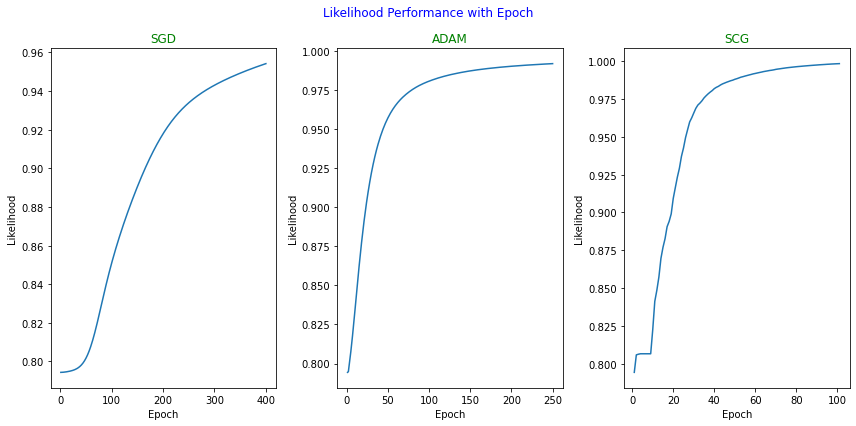

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.suptitle('Likelihood Performance with Epoch', color='blue')

# sgd
sgd_epoch = list(range(1, best_sgd.total_epochs + 1))
plt.subplot(1, 3, 1)
plt.plot(sgd_epoch, best_sgd.performance_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')
plt.title('SGD', color='Green')

# adam
adam_epoch = list(range(1, best_adam.total_epochs + 1))
plt.subplot(1, 3, 2)
plt.plot(adam_epoch, best_adam.performance_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')
plt.title('ADAM', color='Green')

# scg
scg_epoch = list(range(1, best_scg.total_epochs + 1))
plt.subplot(1, 3, 3)
plt.plot(scg_epoch, best_scg.performance_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')
plt.title('SCG', color='Green')

plt.tight_layout()
plt.show()

## Confusion Matrix

In [11]:
import numpy as np

# sgd
print('Confusion Matrix for SGD')
confusion_matrix(best_sgd.use(Xtest)[0], Ttest)

Confusion Matrix for SGD


In [12]:
# Adam
print('Confusion Matrix for ADAM')
confusion_matrix(best_adam.use(Xtest)[0], Ttest)

Confusion Matrix for ADAM


In [13]:
# SCG
print('Confusion Matrix for SCG')
confusion_matrix(best_scg.use(Xtest)[0], Ttest)

Confusion Matrix for SCG


# Accuracies

1. `SGD` best performance - train accuracy <b> 89.44 </b>, validation accuracy <b>90.15</b>, and test accuracy <b>89.40</b>, for a network with a structure `[30, 10]`, learning rate `0.10`, and epoch `400`.

2. `Adam` best performance - train accuracy <b> 98.66 </b>, validation accuracy <b>92.17</b>, and test accuracy <b>91.88</b>, for a network with a structure `[30, 10]`, learning rate `0.01`, and epoch `250`.

3. `SCG` best performance - train acuuracy <b> 99.80 </b>, validation accuracy <b>93.82</b>, and test accuracy <b>93.82</b>, for a network with a structure `[30, 10]`, and epoch `100`.

# Discusiion

Two netwrork structures `[30, 10], [10, 10, 5, 5]`, two learning rates`0.01, 0.1`, and three epoch sizes `100, 250, 400` were tested for this classification algorithms. Three optimizers `SGD, Adam, SCG` were tested.

### Epcoh vs Likelihood
From the `epoch vs likelihood` plots, it can be observed that , among the best models of each optimizer type, `SGD`is the slowest model which runs 400 epochs to get the highest validation score between `SGD` models. `SCG` is the fastest algorithm among these three methods with high validation accuracy `93.82` reaching at only 100 epoch. `Adam` offers a middle ground between these algorithm with high validation accuracy of `92.17` with 250 epoch. 

### Optimization Performance
`SGD` inherently is a slow optimization algorithm, which focuses more on data generalization than optimization speed compared to `Adam`. Analyzing the train vs test accuracy shows that `Adam` overfits a bit to training dataset compared to `SGD`, but has better validation performance. Compared to the other two optimizers, `SCG` has very high training performance of `99.80`. This means `SCG` algorithm overfits the data and might not do welll with new unseen data.

### Confusion Matrix

`SGD` performs relatively poor on test data as observed from confustion matrix of test dataset. Especially, for classes `9`, `5`, and `8`, there are high false negatives. For example, the best SGD model classifies 9.4% and 6.1% of class 9 as 4 and 7, respectively. Such misclassifications are mostly evident in numbers/classes which sometimes become very similar while writing such as 3 and 5, 9 and 4, 5 and 8. `SGD` is a slow optimization algorithm. It might be the case that, with more number of epoch, it will have better performance in recognizing these classes correctly.

`Adam` performs comparatively better than `SGD` in classifying the test dataset. Still high classification error exists between classes 3 and 5, 8 and 5.

`SCG` has the best performance on test data among the three algorithms used in this experiment. But `SCG` overfits on training data and might have poor performance in a entirely new test dataset.


### Conclusion
Overall, `Adam` offers a middle ground between optimization performance, overfitting, and performance on test dataset. `SGD` is very slow and has higher missclassifiation rates even after higher epochs. `SCG` overfits on training dataset and might not perform well on all newly introduced test dataset.

------------

## Check-In

Tar or zip your jupyter notebook (`<name>-A4.ipynb`) and your python script file (`neuralnetworksA4.py`) into a file named `<name>-A4.tar` or `<name>-A4.zip`.  Check in the tar or zip file in Canvas.

# Grading

Download [A4grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.tar), extract `A4grader.py` before running the following cell.

Remember, you are expected to design and run your own tests in addition to the tests provided in `A4grader.py`.

In [11]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Hasan-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

 from neuralnetworksA4 import *

## Testing inheritance ####################################################################

    correct = issubclass(NeuralNetworkClassifier, NeuralNetwork)


--- 10/10 points. NeuralNetworkClassifier correctly extends NeuralNetwork.

## Testing inheritance ####################################################################

    import inspect
    forward_func = [f for f in inspect.classify_class_attrs(NeuralNetworkClassifier) if (f.name == 'forward' or f.name == '_forward')]
    correct = forward_func[0].defining_class == NeuralNetwork


--- 5/5 points. NeuralNetworkClassifier forward function correctly inherited from NeuralNetwork.

## Testing inheritance ############################################################

# Extra Credit

Repeat the above experiments with a different data set.  Randonly partition your data into training, validaton and test parts if not already provided.  Write in markdown cells descriptions of the data and your results.